In [2]:
SEED = 27

In [3]:
import copy
import kornia.augmentation as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autocast, GradScaler
from torch.utils.data import TensorDataset
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import maxvit_t, MaxVit_T_Weights
from ema_pytorch import EMA

In [4]:
X_train = pd.read_csv('../data/train/_classes.csv', usecols=['filename'])
y_train = pd.read_csv('../data/train/_classes.csv').drop(columns=['filename'])

X_val = pd.read_csv('../data/valid/_classes.csv', usecols=['filename'])
y_val = pd.read_csv('../data/valid/_classes.csv').drop(columns=['filename'])

X_test = pd.read_csv('../data/test/_classes.csv', usecols=['filename'])
y_test = pd.read_csv('../data/test/_classes.csv').drop(columns=['filename'])

pd.concat([X_train, y_train], axis=1).head()

,filename,LEVEL_2,LEVEL_3,LEVEL_4,LEVEL_5,LEVEL_6,LEVEL_7
0,6-Top-Down_jpg.rf.4252cf8d3e687a40911d8b5f9da5...,0,0,0,0,0,1
1,21-Top-Down_jpg.rf.f734ee6ad56c1c2ef52282075ba...,0,0,1,0,0,0
2,29-Left_jpg.rf.135d5af193e222e625aabea88f4180a...,0,1,0,0,0,0
3,2-Left_jpg.rf.87838472392bb67c2b54b51a290891b0...,0,0,0,0,1,0
4,9-Back_jpg.rf.46221e6415c7b920153e6ba0980d503d...,1,0,0,0,0,0


In [5]:
# Transforms images from 640x640 to 224x224 tensors
to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [6]:
# Convert images to tensors
X_train_tensor = torch.stack([to_tensor(Image.open(f'../data/train/{fname}')) for fname in X_train['filename']]).squeeze()
X_val_tensor = torch.stack([to_tensor(Image.open(f'../data/valid/{fname}')) for fname in X_val['filename']]).squeeze()
X_test_tensor = torch.stack([to_tensor(Image.open(f'../data/test/{fname}')) for fname in X_test['filename']]).squeeze()

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float16)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float16)

# y_test_tensor is not needed for training

Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
Train_dataset[:5][1]

tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.]], dtype=torch.float16)

In [7]:
Train_dataset[:][0].shape, Train_dataset[:][1].shape

(torch.Size([1294, 3, 224, 224]), torch.Size([1294, 6]))

In [8]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [9]:
# Data augmentation pipeline.
augment = torch.nn.Sequential(
    K.RandomRotation(degrees=(-22.5, 22.5), p=0.5),
    K.RandomResizedCrop(size=(224, 224), scale=(0.7, 1), ratio=(0.9, 1.1), p= 0.6),
    K.RandomEqualize(p=0.6),
    K.RandomGaussianNoise(mean=0, std=0.075, p=0.33),
    K.RandomSaturation(saturation=(0.75, 1.25), p=0.5),
    K.RandomHue(hue=(-0.01, 0.01), p=0.8),
    K.RandomContrast(contrast=(0.8, 1.2), p=0.7),
    K.RandomBrightness(brightness=(0.8, 1.1), p=0.7),
    K.RandomPerspective(distortion_scale=0.2, p=0.33),
    K.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [10]:
def build_maxvit_t():
    """
    Constructs and customizes a MaxViT-T model for classification tasks.

    This function loads a pretrained MaxViT-T model using ImageNet-1K weights, applies selective freezing 
    and dropout adjustments, and modifies the final classification layer to output a single continuous value 
    suitable for classification.

    Parameters
    ----------
    None

    Returns
    -------
    model : torch.nn.Module
        A modified MaxViT-T model with:
        - Pretrained weights from ImageNet-1K.
        - Frozen parameters in the first block (`model.blocks[0]`).
        - Dropout rate set to 0.5 in all Dropout layers outside the frozen block.
        - Final classifier layer replaced with a linear layer outputting a single value instead of the 1000 classes of ImageNet-1K.
    """

    weights = MaxVit_T_Weights.IMAGENET1K_V1
    model = maxvit_t(weights=weights)
    
    # Freeze the parameters of the first block
    for param in model.blocks[0].parameters():
        param.requires_grad = False
    
    # Set dropout rate to 0.5 in all Dropout layers except the first block which is frozen
    for module in model.blocks[1:].modules():
        if isinstance(module, nn.Dropout):
            module.p = 0.5         

    # Modify the final layer to output a single value for classification
    in_features = model.classifier[-1].in_features # 512
    model.classifier[-1] = nn.Linear(in_features, 6)

    return model

In [11]:
Model = build_maxvit_t()

In [12]:
def train_model(model, train_dataset, X_tensor_val, y_tensor_val, epochs=500, batch_size=32, learning_rate=5e-5, scheduler=False, scheduler_patience=50, early_stopping=True, early_stopping_patience=50, smooth=True, show=True):
    """
    Train a PyTorch model using mixed precision, optional EMA smoothing, learning-rate scheduling, and early stopping.

    Parameters
    ----------
    model : torch.nn.Module
        The model to train. The model is moved to a device referenced by the global variable `device`.
    train_dataset : torch.utils.data.Dataset or torch.utils.data.TensorDataset
        Dataset used for training. Batches are drawn with a reproducible Generator seeded inside the function.
    X_tensor_val : torch.Tensor
        Validation feature tensor used for early-stopping evaluation. Sent to `device` when `early_stopping` is True.
    y_tensor_val : torch.Tensor
        Validation label tensor corresponding to `X_tensor_val`. Sent to `device` when `early_stopping` is True.
    epochs : int, optional
        Maximum number of training epochs. Default is 500.
    batch_size : int, optional
        Batch size for the training DataLoader. Default is 32.
    learning_rate : float, optional
        Initial learning rate passed to the AdamW optimizer. Default is 5e-5.
    scheduler : bool, optional
        If True, a StepLR scheduler is created and stepped each epoch. Default is False.
    scheduler_patience : int, optional
        Step size (in epochs) passed to StepLR when `scheduler` is True. Default is 50.
    early_stopping : bool, optional
        If True, validation loss is monitored and training may stop early when no improvement is observed. Default is True.
    early_stopping_patience : int, optional
        Number of consecutive epochs without improvement on the validation loss required to trigger early stopping. Default is 50.
    smooth : bool, optional
        If True, an EMA wrapper is used to maintain a smoothed copy of model weights during training. Default is True.
    show : bool, optional
        If True, periodic progress and validation metrics are printed to stdout. Default is True.

    Returns
    -------
    model : torch.nn.Module
        The trained model. If early stopping was used, the function restores and returns the state corresponding to the best observed validation loss.

    Behavior and Implementation Details
    -----------------------------------
    - The function seeds PyTorch (`torch.manual_seed(27)`) and the DataLoader generator for reproducibility.
    - The model is moved to the global `device`. When `early_stopping` is enabled, validation tensors are moved to `device`.
    - Optimizer: AdamW with the provided `learning_rate` and a small weight decay (1e-8).
    - Loss: L1 loss (mean absolute error) is used as the training and validation criterion.
    - Mixed precision: training uses AMP via `autocast` and a `GradScaler` for stable FP16 updates.
    - EMA smoothing: when `smooth` is True, an `EMA` instance is created and updated after each optimizer step; evaluation uses the EMA copy if available.
    - Data loading: DataLoader is created with `shuffle=True`, a deterministic `Generator` seed, and `pin_memory=True`.
    - Augmentation: each training batch and the validation input passed to the evaluation step are transformed with an `augment` function expected to exist in the calling scope.
    - Scheduler: if `scheduler` is True, a StepLR scheduler with `step_size=scheduler_patience` and `gamma=0.85` is stepped each epoch.
    - Early stopping: when enabled, the function evaluates the model (or EMA model) on the validation tensors each epoch, tracks the best validation loss, saves the best model state_dict, and stops training if no improvement is seen for `early_stopping_patience` consecutive epochs; on early stop the best state is restored before returning the model.

    Notes
    -----
    - The function assumes the existence of the following names in the surrounding scope: `device`, `augment`, `EMA`, and relevant imports for `torch`, `optim`, `nn`, `GradScaler`, and `autocast`.
    - The final returned model is the model with parameters restored to the best validation snapshot if early stopping occurred, otherwise it is the last trained state.
    - The function prints periodic training statistics when `show` is True; printing frequency is every 10 epochs in the provided implementation.
    """

    # Seed for reproducibility
    torch.manual_seed(27)

    # Move model and validation tensors to device
    model = model.to(device)
    if early_stopping:
        X_tensor_val = X_tensor_val.to(device)
        y_tensor_val = y_tensor_val.to(device)

    # Define optimizer, loss function, and scaler for mixed precision
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=1e-8            
    )

    criterion = nn.CrossEntropyLoss()

    scaler = GradScaler()

    # EMA smoothing
    if smooth:
        ema = EMA(
            model,
            beta=0.9999,
            update_after_step=0,
            update_every=1
        )

    # Learning rate scheduler
    if scheduler:
        step_lr = optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=scheduler_patience, 
                                            gamma=0.85)
    # Early stopping variables
    if early_stopping:
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        best_model = None

    # DataLoader with reproducible shuffling
    generator = torch.Generator()
    generator.manual_seed(SEED)

    # Create DataLoader for training
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=generator,
        pin_memory=True
    )

    # Training loop
    for epoch in range(epochs):

        if show:
            total_loss = 0.0

        # Set model to training mode
        model.train()

        # load batches
        for x_batch, y_batch in train_loader:

            # Apply augmentation
            x_batch = augment(x_batch)
            x_batch = x_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass with mixed precision
            with autocast(device_type=device.type):
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)

            # Accumulate loss for reporting
            if show:
                total_loss += loss.item()

            # Backward pass and optimization step with mixed precision
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # EMA update
            if smooth:
                ema.update()

        # Step the learning rate scheduler
        if scheduler:
            step_lr.step()
        
        # Evaluate the EMA model if smoothing is enabled
        model_eval = ema.ema_model if smooth else model

        # Early stopping evaluation
        if early_stopping:

            # Set model to evaluation mode
            model_eval.eval()

            # Set inference mode for model evaluation
            with torch.inference_mode():
                val_outputs = model_eval(X_tensor_val)
                val_loss = criterion(val_outputs, y_tensor_val)
           
            # Check for improvement
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                epochs_without_improvement = 0
                best_model = model_eval.state_dict()
            else:
                epochs_without_improvement += 1

                # Check for early stopping condition
                if epochs_without_improvement >= early_stopping_patience:
                    if show:
                        print(f'No improvement observed in {early_stopping_patience} epochs. Stopping training.')

                    # Restore the model state with the best validation loss
                    model.load_state_dict(best_model)
                    return model

        # Print training progress
        if show and ((epoch + 1) % 25 == 0 or epoch == 0):
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if early_stopping:
                print(f'Best validation loss:{best_val_loss:.4f}')
                print(f'Current validation loss:{val_loss.item():.4f}')
                print("-" * 30)

    # If early stopping was used and it didn't trigger return the model with the best validation loss anyway
    if early_stopping and best_model:
        model.load_state_dict(best_model)

    return model

In [13]:
print(torch.cuda.memory_allocated())

0


In [ ]:
Model = train_model(Model, Train_dataset, X_val_tensor, y_val_tensor)

In [ ]:
torch.save(Model.state_dict(), '../models/state_dicts/maxvit_t_classification.pth')

In [ ]:
Model = build_maxvit_t()
Model.load_state_dict(torch.load('../models/state_dicts/maxvit_t_classification.pth'))
Model = Model.to(device)

In [12]:
# Normalization, the saved tensors are not normalized yet
normalize = K.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def evaluate_model(y_eval, logits_pred):
    """
    Evaluates model predictions against true labels using classification metrics and visualizations.

    This function compares predicted logits to true labels by rescaling, rounding, and one-hot encoding.
    It computes accuracy, mean absolute percentage error (MAPE), and a classification report, and displays
    a confusion matrix and error distribution plot.

    Parameters
    ----------
    y_eval : torch.Tensor
        Ground truth labels as a 1D tensor, expected to be normalized in the range [0, 1].

    logits_pred : torch.Tensor
        Model output logits.

    Returns
    -------
    None
        The function prints evaluation metrics and displays visualizations. It does not return any value.

    Notes
    -----
    - Both `y_eval` and `logits_pred` are rescaled to the original range using: `value * num_categories`.
    - Predictions are clipped to the range [1, num_categories] and rounded to the nearest integer.
    - One-hot encoding is applied to both true and predicted labels for multi-class evaluation.
    - The classification report is computed using `sklearn.metrics.classification_report`.
    - Accuracy is computed as the proportion of exact matches between rounded predictions and labels.
    - Mean Absolute Error (MAE) is calculated as the average absolute difference between predictions and true labels.
    - Mean Absolute Percentage Error (MAPE) is calculated using the absolute error divided by the mean of true values.
    - Quadratic Cohen's Kappa is computed to assess the agreement between true and predicted labels.
    - A confusion matrix heatmap and a KDE plot of prediction error are displayed.
    - Bootstrap resampling (100,000 samples) is used to estimate the mean, standard deviation, and 95% confidence intervals for the metrics.
    """

    # Formatting tensors to numpy arrays
    y_eval = np.argmax(y_eval, axis=1) + 1
    
    y_pred = logits_pred.log_softmax(dim=1).argmax(dim=1) + 1
    y_pred = y_pred.detach().cpu().numpy()
   
    # Bootstrap
    n_samples = 10000
    rng = np.random.default_rng(seed=SEED)
    accuracies = []
    maes = []
    mapes = []
    kappa_scores = []
  
    for _ in range(n_samples):
        indexes = rng.choice(np.arange(len(y_eval)), size=len(y_eval), replace=True)
        y_eval_sample = y_eval[indexes]
        y_pred_sample = y_pred[indexes]
        accuracies.append(np.mean(y_pred_sample == y_eval_sample))
        maes.append(np.mean(np.abs(y_pred_sample - y_eval_sample)))
        mapes.append(np.mean(np.abs(y_pred_sample - y_eval_sample) / (y_eval_sample)) * 100)
        kappa_scores.append(cohen_kappa_score(y_eval_sample, y_pred_sample, weights='quadratic'))
    
    # Bootstrap results
    print(f'Bootstrap results: mean ± std | 95% Confidence Interval over {n_samples} samples')
    print(f'Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f} | CI: [{np.percentile(accuracies, 2.5):.2f} - {np.percentile(accuracies, 97.5):.2f}]')
    print(f'Mean Absolute Error: {np.mean(maes):.2f} ± {np.std(maes):.2f} | CI: [{np.percentile(maes, 2.5):.2f} - {np.percentile(maes, 97.5):.2f}]')
    print(f'Mean Absolute Percentage Error: {np.mean(mapes):.2f} ± {np.std(mapes):.2f} | CI: [{np.percentile(mapes, 2.5):.2f} - {np.percentile(mapes, 97.5):.2f}]')
    print(f'Quadratic Cohen\'s Kappa: {np.mean(kappa_scores):.2f} ± {np.std(kappa_scores):.2f} | CI: [{np.percentile(kappa_scores, 2.5):.2f} - {np.percentile(kappa_scores, 97.5):.2f}]')

    # Confusion Matrix
    cm = confusion_matrix(y_eval, y_pred)
    #error = y_eval - logits_pred
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', ax=ax[0])
    ax[0].set_xlabel('Prediction')
    ax[0].set_ylabel('Real')
    ax[0].set_title('Confusion Matrix')
    sns.histplot(maes, ax=ax[1], color='navy', alpha=0.7, bins=15, kde=True)
    ax[1].axvline(x=np.mean(maes), color='red', linestyle='--', label='Mean')
    ax[1].axvline(x=np.percentile(maes, 2.5), color='green', linestyle='--', label='CI 95%')
    ax[1].axvline(x=np.percentile(maes, 97.5), color='green', linestyle='--')
    ax[1].text(np.percentile(maes, 2.5) - np.std(mapes) * 0.02, len(maes) * 0.2, '2.5%', color='green')
    ax[1].text(np.percentile(maes, 97.5) + np.std(mapes) * 0.0025, len(maes) * 0.2, '97.5%', color='green')
    ax[1].set_title('Bootstrap Mean Absolute Error Distribution')
    ax[1].legend()
    plt.show()


Bootstrap results: mean ± std | 95% Confidence Interval over 10000 samples
Accuracy: 0.70 ± 0.06 | CI: [0.58 - 0.81]
Mean Absolute Error: 0.45 ± 0.10 | CI: [0.27 - 0.66]
Mean Absolute Percentage Error: 17.15 ± 4.75 | CI: [8.86 - 27.39]
Quadratic Cohen's Kappa: 0.84 ± 0.06 | CI: [0.71 - 0.93]


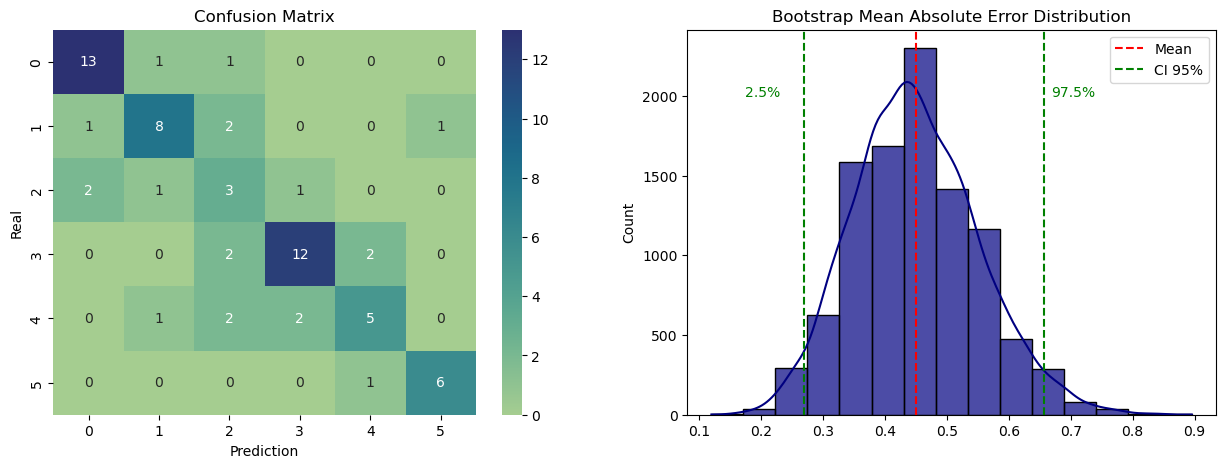

In [13]:
X_test_tensor = normalize(X_test_tensor)

with torch.inference_mode():
    logits_test = Model(X_test_tensor.to(device))
evaluate_model(y_test, logits_test)
del logits_test

Bootstrap results: mean ± std | 95% Confidence Interval over 10000 samples
Accuracy: 0.74 ± 0.04 | CI: [0.67 - 0.82]
Mean Absolute Error: 0.35 ± 0.06 | CI: [0.25 - 0.47]
Mean Absolute Percentage Error: 12.00 ± 2.11 | CI: [8.03 - 16.28]
Quadratic Cohen's Kappa: 0.89 ± 0.02 | CI: [0.84 - 0.93]


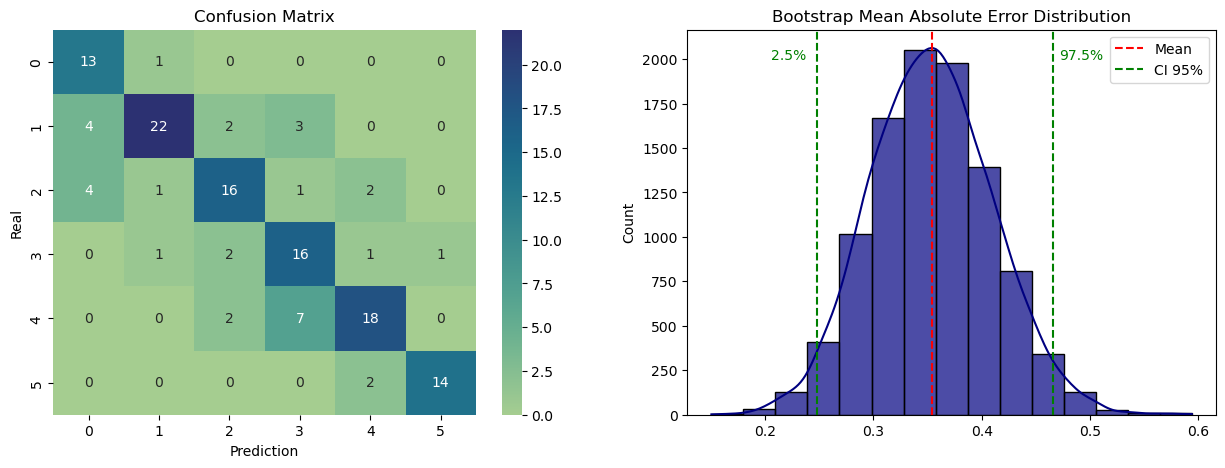

In [14]:
X_val_tensor = normalize(X_val_tensor)

with torch.inference_mode():
    logits_val = Model(X_val_tensor.to(device))
evaluate_model(y_val, logits_val)
del logits_val

Bootstrap results: mean ± std | 95% Confidence Interval over 10000 samples
Accuracy: 1.00 ± 0.00 | CI: [1.00 - 1.00]
Mean Absolute Error: 0.00 ± 0.00 | CI: [0.00 - 0.00]
Mean Absolute Percentage Error: 0.00 ± 0.00 | CI: [0.00 - 0.00]
Quadratic Cohen's Kappa: 1.00 ± 0.00 | CI: [1.00 - 1.00]


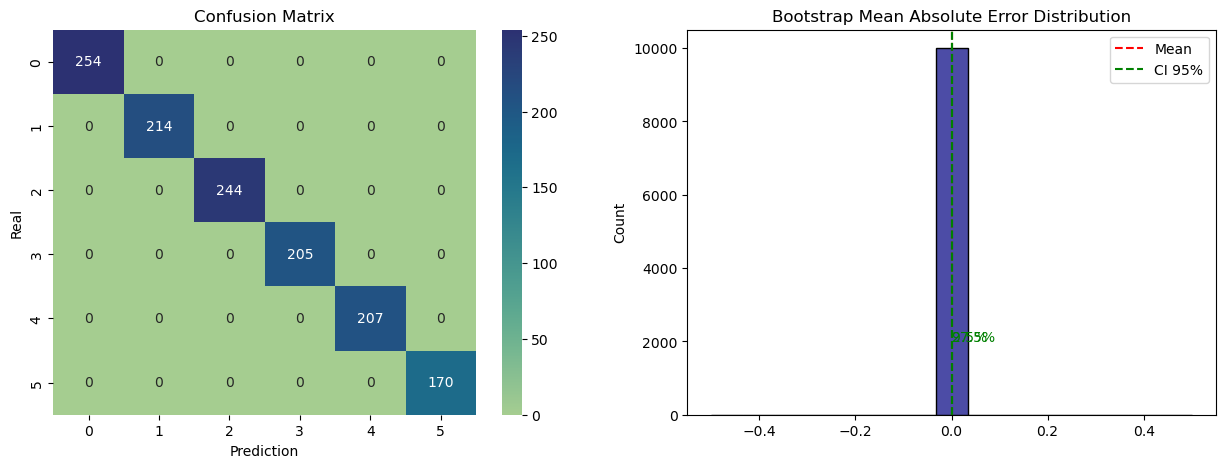

In [16]:
logits_train = torch.tensor([]).to(device)

train_dataloader = torch.utils.data.DataLoader(
    Train_dataset,
    batch_size= 256,
    shuffle=False
)

with torch.inference_mode():
    for x_batch, _ in train_dataloader:
        x_batch = x_batch.to(device)
        x_batch = normalize(x_batch)
        logits_train_batch = Model(x_batch)
        logits_train = torch.cat((logits_train, logits_train_batch), dim=0)
        
evaluate_model(y_train, logits_train)

**Findings**  
Compared to L1loss(MAE), CrossEntropy provides worse metrics in both test and validation sets, moreover it presents an even more extreme overfitting.